<a href="https://colab.research.google.com/github/pedrorostagno/tesis/blob/main/Tesis_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path = '/content/drive/Othercomputers/My Mac/Data/train'

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import os
from PIL import Image
import numpy as np
import pickle

In [ ]:

class CelebASpoofDataset(Dataset):
    def __init__(self, root_dir, transform=None, cache_file=None, max_samples=None):
        """
        root_dir: Ruta raíz del dataset.
        transform: Transformaciones a aplicar a cada imagen.
        cache_file: Ruta al archivo de cache (opcional).
        max_samples: Número máximo de muestras a cargar (opcional).
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        if cache_file is not None and os.path.exists(cache_file):
            print("Cargando dataset desde cache...")
            with open(cache_file, 'rb') as f:
                self.image_paths, self.labels = pickle.load(f)
        else:
            print("Generando la lista de imágenes usando os.scandir...")
            # Variable para determinar si ya se alcanzó el máximo de muestras
            max_reached = False
            with os.scandir(root_dir) as subjects:
                for subject in subjects:
                    if max_samples is not None and len(self.image_paths) >= max_samples:
                        max_reached = True
                        break
                    if subject.is_dir():
                        subject_path = subject.path
                        with os.scandir(subject_path) as type_entries:
                            for entry in type_entries:
                                if max_samples is not None and len(self.image_paths) >= max_samples:
                                    max_reached = True
                                    break
                                if entry.is_dir():
                                    image_type = entry.name  # 'live' o 'spoof'
                                    with os.scandir(entry.path) as files:
                                        for file_entry in files:
                                            if file_entry.is_file() and file_entry.name.lower().endswith(('.jpg', '.png')):
                                                self.image_paths.append(file_entry.path)
                                                self.labels.append(0 if image_type == 'spoof' else 1)
                                                if max_samples is not None and len(self.image_paths) >= max_samples:
                                                    max_reached = True
                                                    break
                                        if max_samples is not None and len(self.image_paths) >= max_samples:
                                            break
                            if max_samples is not None and len(self.image_paths) >= max_samples:
                                break
                    if max_reached:
                        break
            # Guardar en cache si se especifica
            if cache_file is not None:
                with open(cache_file, 'wb') as f:
                    pickle.dump((self.image_paths, self.labels), f)
                print("Cache guardado en", cache_file)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


In [ ]:
# Paths to each split
train_data_dir = '/content/drive/Othercomputers/My Mac/Data/train/train'
val_data_dir = '/content/drive/Othercomputers/My Mac/Data/train/val'
test_data_dir = '/content/drive/Othercomputers/My Mac/Data/train/test'

img_width, img_height = 224, 224
batch_size = 32

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((img_width, img_height)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((img_width, img_height)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((img_width, img_height)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}



In [ ]:
# Datasets con max_samples
train_dataset = CelebASpoofDataset(
    root_dir=train_data_dir,
    transform=data_transforms['train'],
    cache_file='/content/drive/MyDrive/Tesis UTDT/train_dataset_cache.pkl',
    max_samples=5000
)
val_dataset = CelebASpoofDataset(
    root_dir=val_data_dir,
    transform=data_transforms['val'],
    cache_file='/content/drive/MyDrive/Tesis UTDT/val_dataset_cache.pkl',
    max_samples=1000
)
test_dataset = CelebASpoofDataset(
    root_dir=test_data_dir,
    transform=data_transforms['test'],
    cache_file='/content/drive/MyDrive/Tesis UTDT/test_dataset_cache.pkl',
    max_samples=1000
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)



Cargando dataset desde cache...
Cargando dataset desde cache...
Generando la lista de imágenes usando os.scandir...
Cache guardado en /content/drive/MyDrive/Tesis UTDT/test_dataset_cache.pkl


In [ ]:
model = models.mobilenet_v2(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)  # 2 classes: real and fake

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 210MB/s]


In [ ]:
# Device (GPU or CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
# Calcular la distribución de clases a partir del dataset de entrenamiento
labels = np.array(train_dataset.labels)
unique, counts = np.unique(labels, return_counts=True)
print(f"Distribución de clases en entrenamiento: {dict(zip(unique, counts))}")

total = counts.sum()
# Pesos inversos: mayor peso para la clase menos representada
weights = [total / c for c in counts]
weights_tensor = torch.FloatTensor(weights).to(device)
print("Pesos de clases:", weights_tensor)

# Definir la función de pérdida ponderada
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

# El resto de tu código (modelo, optimizador, bucle de entrenamiento) sigue igual.


Distribución de clases en entrenamiento: {0: 3222, 1: 1778}
Pesos de clases: tensor([1.5518, 2.8121], device='cuda:0')


In [ ]:
num_epochs = 10
checkpoint_interval = 1

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)

    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total_samples += inputs.size(0)
        # Print progress every 100 batches

        if (i + 1) % 100 == 0:
          print(f'Batch {i + 1}/{len(train_loader)} - Loss: {loss.item():.4f} - Acc: {(torch.sum(preds == labels.data) / inputs.size(0)):.4f}')

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples
    print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    val_samples = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)
            val_samples += inputs.size(0)

    val_epoch_loss = val_loss / val_samples
    val_epoch_acc = val_corrects.double() / val_samples
    print(f'Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}')

    # Save checkpoint
    if (epoch + 1) % checkpoint_interval == 0:
        checkpoint_path = f'/content/drive/MyDrive/Tesis UTDT/checkpoint_epoch_{epoch + 1}.pth'
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': epoch_loss,
            'train_acc': epoch_acc.item(),
            'val_loss': val_epoch_loss,
            'val_acc': val_epoch_acc.item(),
        }, checkpoint_path)
        print(f'Checkpoint saved to {checkpoint_path}')

print('Finished Training')

# Save the trained model
final_model_path = '/content/drive/MyDrive/Tesis UTDT/real_fake_detection_model.pth'
torch.save(model.state_dict(), final_model_path)
print('Final model saved as real_fake_detection_model.pth')

Epoch 1/10
----------
Batch 100/157 - Loss: 0.0448 - Acc: 0.9688
Train Loss: 0.0829 Acc: 0.9700
Val Loss: 0.2979 Acc: 0.8780
Checkpoint saved to /content/drive/MyDrive/Tesis UTDT/checkpoint_epoch_1.pth
Epoch 2/10
----------
Batch 100/157 - Loss: 0.0153 - Acc: 1.0000
Train Loss: 0.0412 Acc: 0.9866
Val Loss: 0.1330 Acc: 0.9320
Checkpoint saved to /content/drive/MyDrive/Tesis UTDT/checkpoint_epoch_2.pth
Epoch 3/10
----------
Batch 100/157 - Loss: 0.1039 - Acc: 0.9688
Train Loss: 0.0299 Acc: 0.9892
Val Loss: 0.2624 Acc: 0.9250
Checkpoint saved to /content/drive/MyDrive/Tesis UTDT/checkpoint_epoch_3.pth
Epoch 4/10
----------
Batch 100/157 - Loss: 0.0250 - Acc: 0.9688
Train Loss: 0.0352 Acc: 0.9882
Val Loss: 0.1476 Acc: 0.9750
Checkpoint saved to /content/drive/MyDrive/Tesis UTDT/checkpoint_epoch_4.pth
Epoch 5/10
----------
Batch 100/157 - Loss: 0.1123 - Acc: 0.9375
Train Loss: 0.0245 Acc: 0.9918
Val Loss: 0.2124 Acc: 0.9200
Checkpoint saved to /content/drive/MyDrive/Tesis UTDT/checkpoint_ep

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import sklearn.metrics as metrics
import time

# Función para entrenar una época (Mixed Precision Training)
def train_epoch(model, train_loader, optimizer, criterion, device, scaler):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total_samples += inputs.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples
    return epoch_loss, epoch_acc

# Función para validar una época y calcular métricas adicionales
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = val_loss / total_samples
    epoch_acc = val_corrects.double() / total_samples
    # Reporte de métricas adicionales (por ejemplo, F1-score macro)
    report = metrics.classification_report(all_labels, all_preds, output_dict=True, zero_division=0)

    return epoch_loss, epoch_acc, report, all_preds, all_labels

# Función principal de entrenamiento que integra early stopping y TensorBoard
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, patience=3, checkpoint_interval=1, log_dir='logs/exp1'):
    writer = SummaryWriter(log_dir=log_dir)
    scaler = GradScaler()
    best_val_loss = float('inf')
    trigger_times = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Entrenamiento
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device, scaler)
        print(f'Train Loss: {train_loss:.4f}  Acc: {train_acc:.4f}')

        # Validación
        val_loss, val_acc, report, all_preds, all_labels = validate_epoch(model, val_loader, criterion, device)
        print(f'Val Loss: {val_loss:.4f}  Acc: {val_acc:.4f}')
        print(metrics.classification_report(all_labels, all_preds, target_names=["spoof", "live"], zero_division=0))

        # Registro de métricas en TensorBoard
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Acc/train', train_acc, epoch)
        writer.add_scalar('Acc/val', val_acc, epoch)
        macro_f1 = report['macro avg']['f1-score']
        writer.add_scalar('F1/macro_val', macro_f1, epoch)

        # Early Stopping: Si la pérdida de validación mejora, se guarda el mejor modelo.
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger_times = 0
            torch.save(model.state_dict(), 'best_model.pth')
            print('Best model saved')
        else:
            trigger_times += 1
            print(f'Early stopping trigger: {trigger_times}/{patience}')
            if trigger_times >= patience:
                print("Early stopping!")
                break

        # Guardar checkpoint cada checkpoint_interval épocas
        if (epoch+1) % checkpoint_interval == 0:
            checkpoint_path = f'checkpoint_epoch_{epoch+1}.pth'
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'train_acc': train_acc.item(),
                'val_loss': val_loss,
                'val_acc': val_acc.item(),
            }, checkpoint_path)
            print(f'Checkpoint saved to {checkpoint_path}')

    writer.close()
    return model

# Ejemplo de uso:
# Asumiendo que ya tienes definido:
# - model (por ejemplo, MobileNetV2 modificado)
# - train_loader, val_loader (DataLoaders)
# - criterion (por ejemplo, nn.CrossEntropyLoss con o sin pesos)
# - optimizer (por ejemplo, optim.Adam(model.parameters(), lr=0.001))
# - device (por ejemplo, torch.device("cuda:0") si hay GPU)
#
# Luego, para entrenar:
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, patience=3)


Epoch 1/10
----------


<ipython-input-17-ae200ec3e4dd>:76: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-17-ae200ec3e4dd>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.0154  Acc: 0.9942


<ipython-input-17-ae200ec3e4dd>:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Val Loss: 0.1899  Acc: 0.9140
              precision    recall  f1-score   support

       spoof       0.99      0.87      0.93       634
        live       0.82      0.99      0.89       366

    accuracy                           0.91      1000
   macro avg       0.90      0.93      0.91      1000
weighted avg       0.93      0.91      0.92      1000

Best model saved
Checkpoint saved to checkpoint_epoch_1.pth
Epoch 2/10
----------


<ipython-input-17-ae200ec3e4dd>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.0088  Acc: 0.9970


<ipython-input-17-ae200ec3e4dd>:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Val Loss: 0.0756  Acc: 0.9660
              precision    recall  f1-score   support

       spoof       1.00      0.95      0.97       634
        live       0.92      1.00      0.96       366

    accuracy                           0.97      1000
   macro avg       0.96      0.97      0.96      1000
weighted avg       0.97      0.97      0.97      1000

Best model saved
Checkpoint saved to checkpoint_epoch_2.pth
Epoch 3/10
----------


<ipython-input-17-ae200ec3e4dd>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.0047  Acc: 0.9984


<ipython-input-17-ae200ec3e4dd>:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Val Loss: 0.0808  Acc: 0.9650
              precision    recall  f1-score   support

       spoof       1.00      0.95      0.97       634
        live       0.92      0.99      0.95       366

    accuracy                           0.96      1000
   macro avg       0.96      0.97      0.96      1000
weighted avg       0.97      0.96      0.97      1000

Early stopping trigger: 1/3
Checkpoint saved to checkpoint_epoch_3.pth
Epoch 4/10
----------


<ipython-input-17-ae200ec3e4dd>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.0158  Acc: 0.9940


<ipython-input-17-ae200ec3e4dd>:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Val Loss: 0.0391  Acc: 0.9900
              precision    recall  f1-score   support

       spoof       0.99      1.00      0.99       634
        live       0.99      0.98      0.99       366

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

Best model saved
Checkpoint saved to checkpoint_epoch_4.pth
Epoch 5/10
----------


<ipython-input-17-ae200ec3e4dd>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.0294  Acc: 0.9888


<ipython-input-17-ae200ec3e4dd>:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Val Loss: 0.0473  Acc: 0.9880
              precision    recall  f1-score   support

       spoof       0.98      1.00      0.99       634
        live       0.99      0.97      0.98       366

    accuracy                           0.99      1000
   macro avg       0.99      0.98      0.99      1000
weighted avg       0.99      0.99      0.99      1000

Early stopping trigger: 1/3
Checkpoint saved to checkpoint_epoch_5.pth
Epoch 6/10
----------


<ipython-input-17-ae200ec3e4dd>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.0296  Acc: 0.9922


<ipython-input-17-ae200ec3e4dd>:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Val Loss: 0.0927  Acc: 0.9620
              precision    recall  f1-score   support

       spoof       0.99      0.95      0.97       634
        live       0.91      0.99      0.95       366

    accuracy                           0.96      1000
   macro avg       0.95      0.97      0.96      1000
weighted avg       0.96      0.96      0.96      1000

Early stopping trigger: 2/3
Checkpoint saved to checkpoint_epoch_6.pth
Epoch 7/10
----------


<ipython-input-17-ae200ec3e4dd>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.0148  Acc: 0.9954


<ipython-input-17-ae200ec3e4dd>:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Val Loss: 0.0399  Acc: 0.9830
              precision    recall  f1-score   support

       spoof       1.00      0.98      0.99       634
        live       0.96      0.99      0.98       366

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

Early stopping trigger: 3/3
Early stopping!


Cargando dataset desde cache...


<ipython-input-24-9a5e2b61b5c5>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Test Loss: 1.2223
Matriz de Confusión:
[[2190 3135]
 [  32 4643]]
Reporte de Clasificación:
              precision    recall  f1-score   support

       spoof       0.99      0.41      0.58      5325
        live       0.60      0.99      0.75      4675

    accuracy                           0.68     10000
   macro avg       0.79      0.70      0.66     10000
weighted avg       0.80      0.68      0.66     10000



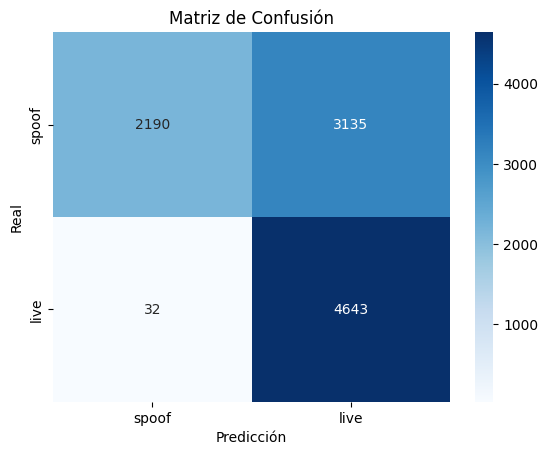

In [ ]:
import numpy as np
import sklearn.metrics as metrics
import seaborn as sns
import matplotlib.pyplot as plt
import torch

def test_model(model, test_loader, criterion, device):
    model.eval()
    all_preds = []
    all_labels = []
    test_loss = 0.0
    total_samples = 0

    # Usar autocast para precisión mixta en la inferencia
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            test_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = test_loss / total_samples
    print(f'Test Loss: {avg_loss:.4f}')

    # Convertir a arrays de numpy
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calcular la matriz de confusión y el reporte de clasificación
    cm = metrics.confusion_matrix(all_labels, all_preds)
    report = metrics.classification_report(all_labels, all_preds, target_names=["spoof", "live"], zero_division=0)

    print("Matriz de Confusión:")
    print(cm)
    print("Reporte de Clasificación:")
    print(report)

    # Visualizar la matriz de confusión
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["spoof", "live"],
                yticklabels=["spoof", "live"])
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title("Matriz de Confusión")
    plt.show()

    return avg_loss, report, cm

test_data_dir2 = '/content/drive/Othercomputers/My Mac/Data/test'

test_dataset2 = CelebASpoofDataset(
    root_dir=test_data_dir2,
    transform=data_transforms['test'],
    cache_file='/content/drive/MyDrive/Tesis UTDT/test_dataset_cache2.pkl',
    max_samples=10000
)


# DataLoaders
test_loader2 = DataLoader(test_dataset2, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)


# Ejemplo de uso:
test_loss, test_report, test_cm = test_model(model, test_loader2, criterion, device)
